# Redes neuronales

### Autor: Luis Ardévol Mesa

## Ejercicio 2

Antes de comenzar, verificamos que el entorno de ejecución esté configurado con las librerías necesarias (no ejecutar en cesga).

In [3]:
import subprocess
import sys
import pkg_resources

def check_and_install_packages():
    required_packages = {
        'pandas': 'pandas',
        'numpy': 'numpy',
        'scikit-learn': 'scikit-learn',
        'matplotlib': 'matplotlib'
    }
    
    missing_packages = []
    
    # Verificar paquetes instalados
    installed_packages = {pkg.key for pkg in pkg_resources.working_set}
    
    for package, pip_name in required_packages.items():
        if package not in installed_packages:
            missing_packages.append(pip_name)
    
    # Instalar paquetes faltantes
    if missing_packages:
        print("Instalando paquetes necesarios...")
        for package in missing_packages:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        print("Instalación completada.")
    else:
        print("Todos los paquetes necesarios ya están instalados.")

check_and_install_packages()

Todos los paquetes necesarios ya están instalados.


Ahora importamos las librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline
#matplotlib.style.use('seaborn-v0_8-ticks')

**Definición de variables globales**

In [2]:
DATASET_NAME = 'bloodTransfusion.data'
DATASET_DELIMITER = ','
SEED_VALUE = 1  # NO CAMBIES ESTA SEMILLA, así todos tendremos los mismos resultados

**Lectura del fichero de datos**

In [4]:
dataset = pd.read_csv(DATASET_NAME, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1, # la primera fila no contiene datos
                      header=None,
                      names = ["X0", "X1", "X2", "X3", "Y"])
dataset

,X0,X1,X2,X3,Y
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


**Exploración de los datos**

A continuación, vemos si hay valores perdidos en nuestro conjunto de datos (en caso afirmativo, haremos el tratamiento más adelante). Visualizamos también estadísticas descriptivas de las variables predictoras. En este caso, Y no interesa tanto ya que es una variable binaria. Veremos su distribución de clases más adelante. 

In [5]:
print(f"Valores faltantes: \n{dataset.isnull().sum()}\n")
print("Estadísticas de los predictores:")
dataset.loc[:, "X0":"X3"].describe()

Valores faltantes: 
X0    0
X1    0
X2    0
X3    0
Y     0
dtype: int64

Estadísticas de los predictores:


,X0,X1,X2,X3
count,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086
std,8.095396,5.839307,1459.826781,24.376714
min,0.000000,1.000000,250.000000,2.000000
25%,2.750000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


El fichero contiene 5 variables y 748 observaciones distintas. Las variables predictoras son `X0`, `X1`, `X2`, `X3`, y la variable dependiente sería `Y`. Estamos ante un problema de clasificación binario (dada la naturaleza booleana de `Y`, existen 2 clases).

**Visualización de los datos**

Distribución de clases en la variable de salida: 
0    570
1    178
Name: Y, dtype: int64


/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


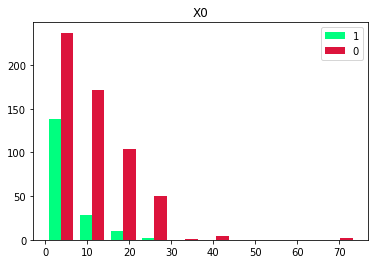

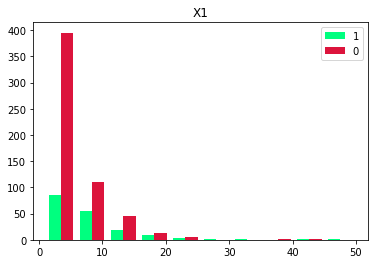

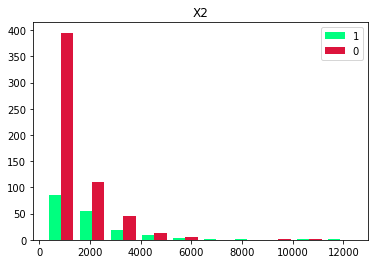

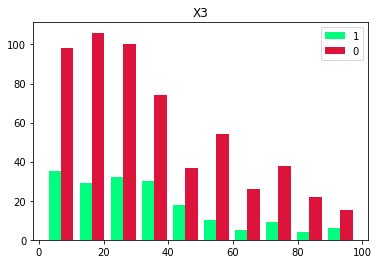

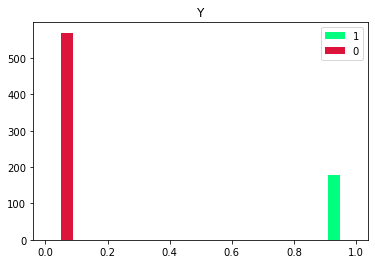

In [6]:
def distClases(data, etiquetas = ['1', '0'], colores=['springgreen', 'crimson']):
    print(f"Distribución de clases en la variable de salida: \n{data['Y'].value_counts()}")
    
    for column in data:  # Visualizamos la distribución de variables por clases
        plt.title(column)
        clases = [data[data['Y'] == eval(i)][column] for i in etiquetas]
        plt.hist(clases, label=etiquetas, color=colores)
        plt.legend(loc='upper right')
        plt.show()


distClases(dataset)

También podemos visualizar los datos y sus clases por pares de atributos:

Correlación numérica entre las variables: 
          X0        X1        X2        X3         Y
X0  1.000000 -0.182745 -0.182745  0.160618 -0.279869
X1 -0.182745  1.000000  1.000000  0.634940  0.218633
X2 -0.182745  1.000000  1.000000  0.634940  0.218633
X3  0.160618  0.634940  0.634940  1.000000 -0.035854
Y  -0.279869  0.218633  0.218633 -0.035854  1.000000


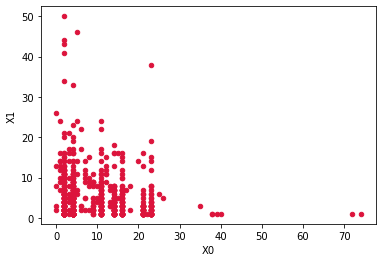

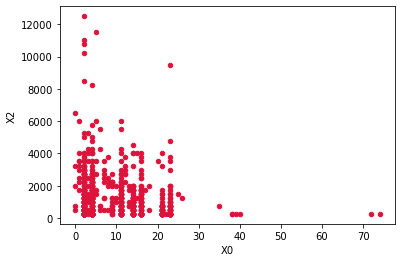

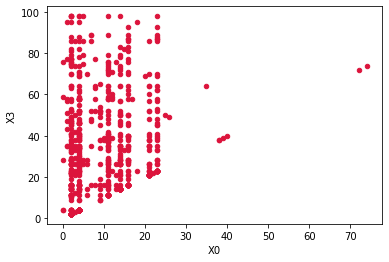

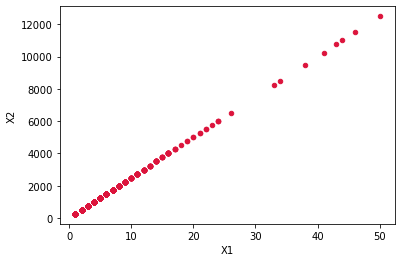

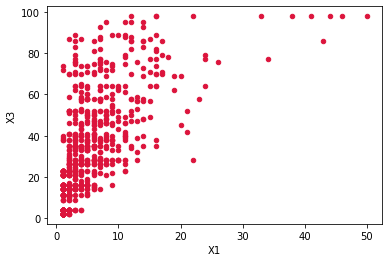

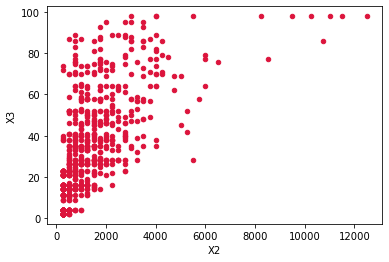

In [7]:
def distPares(data):
    print(f"Correlación numérica entre las variables: \n{data.corr()}") # correlación entre las variables

    column_names = data.columns[:-1]  # Omitimos la variable dependiente
    # Ahora representamos atributos por pares (mostrando también la clase)
    column_names = data.columns[:-1]  # Omitimos la variable dependiente
    for i, columna_i in enumerate(column_names):
        for j, columna_j in enumerate(column_names):
            if i < j:
                fig, ax = plt.subplots()
                data.plot.scatter(columna_i, columna_j, c='crimson', ax=ax)

distPares(dataset)

### División de los datos en entrenamiento (80%) y test (20%)

Para la división de datos entre entrenamiento (80%) y test (20%) usamos `train_test_split`.

In [8]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=SEED_VALUE, stratify=dataset["Y"])
dataset_test

,X0,X1,X2,X3,Y
309,16,3,750,19,0
711,23,6,1500,45,0
343,11,1,250,11,0
462,21,1,250,21,1
646,14,2,500,14,0
...,...,...,...,...,...
315,4,2,500,29,0
473,14,3,750,83,0
661,16,2,500,16,0
362,4,3,750,71,0


**Gestión de valores faltantes**

Como ya vimos en la breve exploración e los datos, nuestro dataset no tiene valores faltantes.
Sin embargo, la sustitución de las variables predictoras por la media se llevaría a cabo de la siguiente manera. `SimpleImputer` convierte nuestros valores a un array NumPy, por lo que sería bueno que se vuelven a convertir a formato dataframe.

In [9]:
def valoresFaltantes(trainData, testData, mis_val=np.nan, fill_val='mean'):
    imp = SimpleImputer(missing_values=mis_val, fill_value=fill_val) # definimos el mapa
    imp = imp.fit(trainData)  # La media la calculamos SÓLO a partir del conjunto de train 

    # Los valores van a ser los mismos que antes, pues no tenemos datos faltantes
    dataset_train_prep = imp.transform(trainData) # aqui modificamos los datos de train
    dataset_test_prep = imp.transform(testData) # aqui modificamos los datos de test (se usa la media de entrenamiento)

    dataset_train = pd.DataFrame(dataset_train_prep, 
                                 columns=trainData.columns, 
                                 index=trainData.index)
    dataset_test = pd.DataFrame(dataset_test_prep, 
                                columns=testData.columns, 
                                index=testData.index)

    return dataset_train, dataset_test

dataset_train, dataset_test = valoresFaltantes(dataset_train, dataset_test)
dataset_test

,X0,X1,X2,X3,Y
309,16.0,3.0,750.0,19.0,0.0
711,23.0,6.0,1500.0,45.0,0.0
343,11.0,1.0,250.0,11.0,0.0
462,21.0,1.0,250.0,21.0,1.0
646,14.0,2.0,500.0,14.0,0.0
...,...,...,...,...,...
315,4.0,2.0,500.0,29.0,0.0
473,14.0,3.0,750.0,83.0,0.0
661,16.0,2.0,500.0,16.0,0.0
362,4.0,3.0,750.0,71.0,0.0


### Separación de variables predictoras y dependientes y estandarización de los datos

Es recomendable hacer siempre la estandarización de los datos. Esto hay que hacerlo **DESPUÉS** de dividir en conjuntos de entrenamiento y test. En los problemas de clasificación, **NO** estandarizaremos la variable dependiente, pero esto sí es necesario en problemas de regresión.

Definimos una función que, dada los datos de entrenamiento y *test*, separa las varibles predictoras y dependientes (especificadas en los parámetros `preds` y `dep`), y estandariza las variables predictoras o las predictoras y las dependientes (el parámetro `escalar = [True, True]` controla el escalado de las variables: el primer elemento indica si se estandarizan las variables predictoras o no (en este último caso da error, ya que es necesario), y el segundo elemento hace lo mismo con las variables dependientes). 

In [10]:
def splitScale(trainData, testData, preds = ['X0', 'X1', 'X2', 'X3'], dep = 'Y', escalar = [True, True]):

    dataset_train_X = trainData.loc[:, preds[0]:preds[-1]].astype(float)
    dataset_train_Y = trainData.loc[:, dep].astype(float)

    dataset_test_X = testData.loc[:, preds[0]:preds[-1]].astype(float)
    dataset_test_Y = testData.loc[:, dep].astype(float)

    if escalar[0]:
        scalerX = StandardScaler() # creamos el scaler
        scalerX.fit(dataset_train_X) # ajustamos a los datos de TRAIN

        dataset_train_X_scaled = scalerX.transform(dataset_train_X)
        dataset_test_X_scaled = scalerX.transform(dataset_test_X)

        print("Valores con los que se ha estandarizado:\n")
        
        statsPreds = pd.DataFrame([scalerX.mean_, scalerX.scale_], 
                                  index = ['Mean', 'std'], 
                                  columns = preds)
        print(f"{statsPreds}\n")

        if escalar[1]:
            
            dataset_train_Y = dataset_train_Y.to_frame()
            dataset_test_Y = dataset_test_Y.to_frame()
            
            scalerY = StandardScaler()
            scalerY.fit(dataset_train_Y) # ajustamos a los datos de TRAIN

            dataset_train_Y_scaled = scalerY.transform(dataset_train_Y)
            dataset_test_Y_scaled = scalerY.transform(dataset_test_Y)

            statsDep = pd.DataFrame([scalerY.mean_, scalerY.scale_], 
                                    index = ['Mean', 'std'], 
                                    columns = [dep])
            print(statsDep)

            return dataset_train_X_scaled, dataset_train_Y_scaled, dataset_test_X_scaled, dataset_test_Y_scaled, [scalerX, scalerY]
        
        return dataset_train_X_scaled, dataset_train_Y, dataset_test_X_scaled, dataset_test_Y, scalerX
    
    else: 
        raise ValueError("Es necesario escalar los predictores")

In [11]:
dataset_train_X_scaled, dataset_train_Y, dataset_test_X_scaled, dataset_test_Y, scalerX = splitScale(dataset_train, dataset_test, preds = ['X0', 'X1', 'X2', 'X3'], dep = 'Y', escalar=[True, False])

Valores con los que se ha estandarizado:

            X0        X1           X2         X3
Mean  9.508361  5.637124  1409.280936  34.879599
std   7.893041  5.893176  1473.294031  24.729957



### Exploración de hiperparámetros

Hemos visualizado y preprocesado los datos. Vamos a empezar a trabajar con nuestro predictor. Importante conocer los hiperparámetros del modelo a usar. Debemos sobreaprender y subaprender. Primero hacemos exploracion de hiperparámetros de grano grueso y luego de grano fino.

`GridSearch` admite una gran variedad de modelos, por lo que definir una función que lo aplique resultará de utilidad. Pasando el modelo a usar el *grid* de hiperparámetros, obtenemos los resultados de los modelos explorados. Además, como lo usaremos con frecuencia, añadimos una columna a los resultados calculando el error medio. 

In [12]:
def crossVal(trainDataX, trainDataY, modelo, hiperparametros, cv = 5, scoring = 'accuracy'):
    modelCV = GridSearchCV(modelo, 
                           param_grid = hiperparametros, # grid de hiperparametros
                           cv = cv, # conjuntos de validacion cruzada (folds)
                           scoring = scoring, # metrica de evaluacion 
                           return_train_score = True)
    
    np.random.seed(SEED_VALUE) 
    modelCV.fit(trainDataX, trainDataY)
    resultados = pd.DataFrame(modelCV.cv_results_)
    
    if scoring == 'accuracy': 
        resultados['mean_test_error'] = 1 - resultados.loc[:, 'mean_test_score']

    return modelCV, resultados

**Exploración de grano grueso**

En esta práctica, exploraremos el parámetro de regularización (`alpha` en `scikit-learn`) y el número de capas (variando entre 1 y 3), así como el número de neuronas en cada capa (que supondremos el mismo en todas las capas). Hacemos primero una exploración de valores en un rango amplio (gg), para subaprender y sobreaprender. De este modo, luego seleccionaremos un rango más limitado de este parámetro y podremos explorar todas las posibilidades en el mismo. 

Concretamente, seleccionamos valores de `alpha` entre 0.001 y 100, en potencias de 10 (0.001, 0.01, 0.1, 1, 10, 100), y de número de capas entre 1 y 3. Cada capa tendrá el mismo número de neuronas, que variará entre 1 y 51, en pasos de 10. Usamos como función de activación la tangente hiperbólica y como algoritmo de optimización el BFGS limitado en memoria. Fijamos un máximo de 2000 iteraciones.

In [15]:
hidden_gg = [(n,) for n in range(1, 52, 10)] + [(n, n) for n in range(1, 52, 10)] + [(n, n, n) for n in range(1, 52, 10)]

alpha_gg = [1 * 10**p for p in range(-3, 3)]

hyperparameters_gg = {'hidden_layer_sizes': hidden_gg, 'alpha': alpha_gg}

# Configurar el modelo
mlp_gg = MLPClassifier(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)

modeloCV_gg, cv_results_gg = crossVal(dataset_train_X_scaled, np.ravel(dataset_train_Y.astype(int)), 
                                      mlp_gg, hyperparameters_gg)
modeloCV_gg

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn

GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', max_iter=2000,
                                     random_state=1, solver='lbfgs'),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                         'hidden_layer_sizes': [(1,), (11,), (21,), (31,),
                                                (41,), (51,), (1, 1), (11, 11),
                                                (21, 21), (31, 31), (41, 41),
                                                (51, 51), (1, 1, 1),
                                                (11, 11, 11), (21, 21, 21),
                                                (31, 31, 31), (41, 41, 41),
                                                (51, 51, 51)]},
             return_train_score=True, scoring='accuracy')

**Gráfica de entrenamiento (primera aproximación)**

Aqui deberiamos tener una grafica más o menos convexa para ver que ahi esta el minimo. Hacemos una función que grafique el error frente al número de neuronas por capa; mostraremos una gráfica para cada valor de `alpha`, dibujando tres *plots* en cada una, uno para cada número de capas.

In [13]:
def errorVal(resultados, fig, label = 'uniform', color = 'crimson', classification = True, num_capas=None):

    if classification:
        resultados['mean_test_error'] = 1 - resultados['mean_test_score']
    
    else:
        resultados['mean_test_error'] = resultados['mean_test_score'] # para no cambiar el resto de codigo y evitar ifs

    results = pd.DataFrame({'hidden_layer_sizes': resultados['param_hidden_layer_sizes'], 
                            'alpha': resultados['param_alpha'], 
                            'mean_test_error': resultados['mean_test_error'], 
                            'std_test_score': resultados['std_test_score'], 
                            'rank_test_score': resultados['rank_test_score']})

    results['num_capas'] = results['hidden_layer_sizes'].apply(len)
    results['num_neuronas'] = results['hidden_layer_sizes'].apply(lambda x: x[0])
    
    alphas = np.unique(results['alpha'])
    
    colores = ['crimson', 'springgreen', 'navy'] if isinstance(color, str) else color

    for ax, alpha in zip(fig.axes, alphas):
        resultados_alpha = results[results['alpha'] == alpha]
        vals_num_capas = sorted(resultados_alpha['num_capas'].unique()) if num_capas is None else num_capas

        for idx, n_layers in enumerate(vals_num_capas):
            color = colores[idx]
                
            datos = resultados_alpha[resultados_alpha['num_capas'] == n_layers]
            ax.errorbar(datos['num_neuronas'], datos['mean_test_error'], yerr = datos['std_test_score'], 
                        label = f"{n_layers} capas {label}", color = color, capsize = 3)
        
        ax.set_title(f'Alpha = {alpha}')
        ax.set_xlabel("Número de neuronas por capa")
        ax.set_ylabel("Error de entrenamiento")
        ax.legend()
        ax.grid(axis='y', alpha=0.5)
    
    return ax

Hacemos la representación de los resultados de la exploracion de grano grueso.

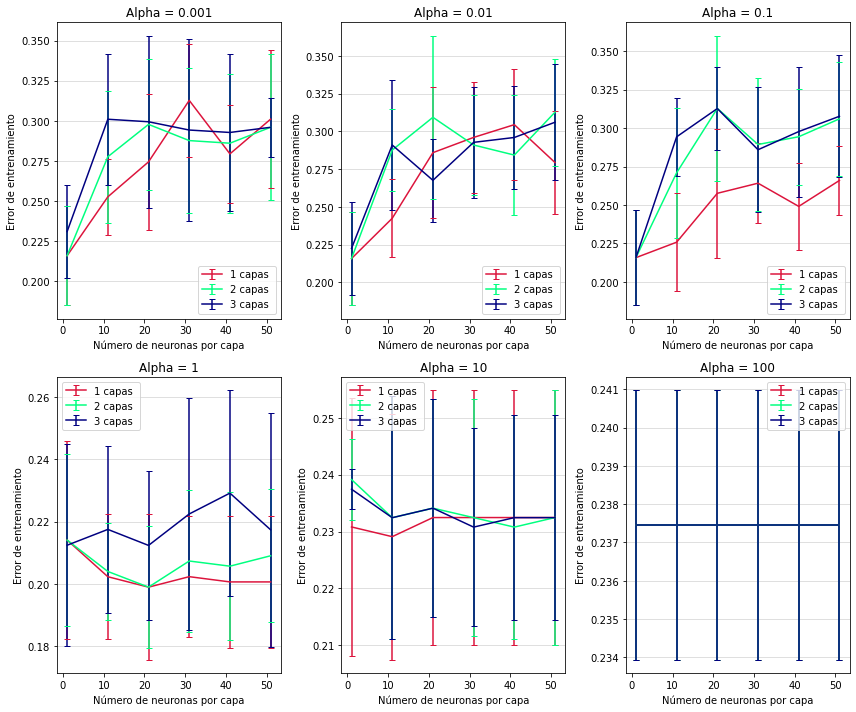

In [17]:
fig_gg, axes_gg = plt.subplots(2, int(len(alpha_gg)/2), figsize=(int(4*len(alpha_gg)/2), 5*2))

errorVal(cv_results_gg, fig_gg, label='')

plt.tight_layout()
plt.show()

Buscamos una gráfica más o menos convexa, para hacer una búsqueda de grano fino en el entorno del mínimo. Además, nos interesa que el mínimo tenga el menor error posible. Nos fijamos entonces en las gráficas con el parámetro de regularizacion igual a 1, con una o dos capas ocultas. Estas dos son, las curvas convexas que presentan un error más bajo, por lo que los hiperparámetros óptimos se deberían encontrar con estos valores.  

**Exploración de grano fino**

Repetimos la exploración, esta vez barriendo todos los valores del intervalo. Así encontraremos el modelo con el menor error de validación cruzada para este problema. Concretamente, usaremos una y dos capas ocultas, con entre 1 y 40 neuronas cada capa (de uno en uno). Para el parámetro de regularizacion, cogeremos 1 y su entorno, es decir, 0.5 y 5; esto nos da más precisión a la hora de buscar el valor óptimo. 

In [18]:
hidden_gf = [(n,) for n in range(1, 41, 1)] + [(n, n) for n in range(1, 41, 1)]
alpha_gf = [0.5, 1, 5]

hyperparameters_gf = {'hidden_layer_sizes': hidden_gf, 'alpha': alpha_gf}
mlp_gf = MLPClassifier(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)

modeloCV_gf, cv_results_gf = crossVal(dataset_train_X_scaled, np.ravel(dataset_train_Y.astype(int)), 
                                      mlp_gf, hyperparameters_gf)
modeloCV_gf

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn

GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', max_iter=2000,
                                     random_state=1, solver='lbfgs'),
             param_grid={'alpha': [0.5, 1, 5],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (8,), (9,), (10,),
                                                (11,), (12,), (13,), (14,),
                                                (15,), (16,), (17,), (18,),
                                                (19,), (20,), (21,), (22,),
                                                (23,), (24,), (25,), (26,),
                                                (27,), (28,), (29,), (30,), ...]},
             return_train_score=True, scoring='accuracy')

Veamos el mejor modelo y sus estadísticas:

In [19]:
cv_results_best_gf = cv_results_gf[cv_results_gf['rank_test_score'] == 1]
cv_results_best_gf.loc[:, ['param_alpha', 'param_hidden_layer_sizes', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_alpha,param_hidden_layer_sizes,mean_test_score,mean_test_error,std_test_score,rank_test_score
2,0.5,"(3,)",0.805994,0.194006,0.029822,1


**Gráfica de entrenamiento**

A continuación mostramos la gráfica del error de entrenamiento con validación cruzada frente al número de neuronas por capa, para cada número de capas ocultas y para cada valor de `alpha`.

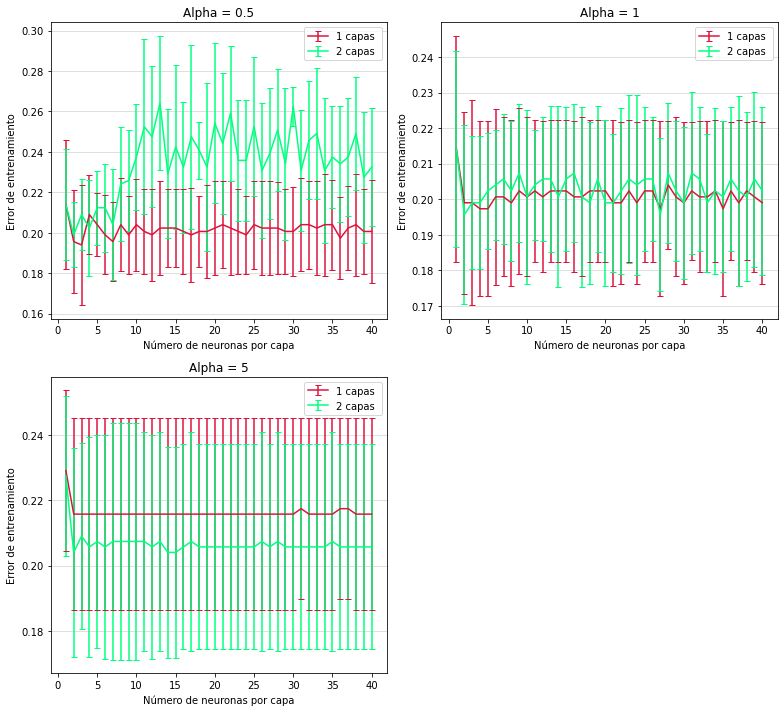

In [ ]:
fig_gf, axes_gf = plt.subplots(2, int(len(alpha_gf)/2)+1, figsize=(int(7*len(alpha_gf)/2)+1, 5*2))

errorVal(cv_results_gf, fig_gf, label="")

fig_gf.delaxes(axes_gf.flatten()[-1]) # quitamos el eje vacio

plt.tight_layout()
plt.savefig("ej2_1.pdf", dpi=150)
plt.show()

Aquí podemos ver visualmente los resultados anteriores: el mejor modelo lo tenemos con una única capa oculta de 3 neuronas, y un valor de `alpha` de 0.5.

### Verificación de hiperparámetros en *test*

Esto no se haría **JAMÁS** en una situación real. Pero como este es un ejemplo para aprender, vamos a ver cómo de lejos nos hemos quedado de los hiperparámetros "ideales". Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos).

In [21]:
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold) # fijamos una particion de datos (forzamos al metodo a que particione como queremos)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

mlp = MLPClassifier(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)

modeloCV_test, cv_results_test = crossVal(dataset_all_X_scaled, np.ravel(dataset_all_Y.astype(int)), 
                                          mlp, hyperparameters_gf, cv = ps)
modeloCV_test

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MLPClassifier(activation='tanh', max_iter=2000,
                                     random_state=1, solver='lbfgs'),
             param_grid={'alpha': [0.5, 1, 5],
                         'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                (6,), (7,), (8,), (9,), (10,),
                                                (11,), (12,), (13,), (14,),
                                                (15,), (16,), (17,), (18,),
                                                (19,), (20,), (21,), (22,),
                                                (23,), (24,), (25,), (26,),
                                                (27,), (28,), (29,), (30,), ...]},
             return_train_score=True, scoring='accuracy')

Ahora mostramos la gráfica del error de *test* frente al valor del hiperparámetro junto con la del error de entrenamiento, lo que permitirá comparar si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de *test*.

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


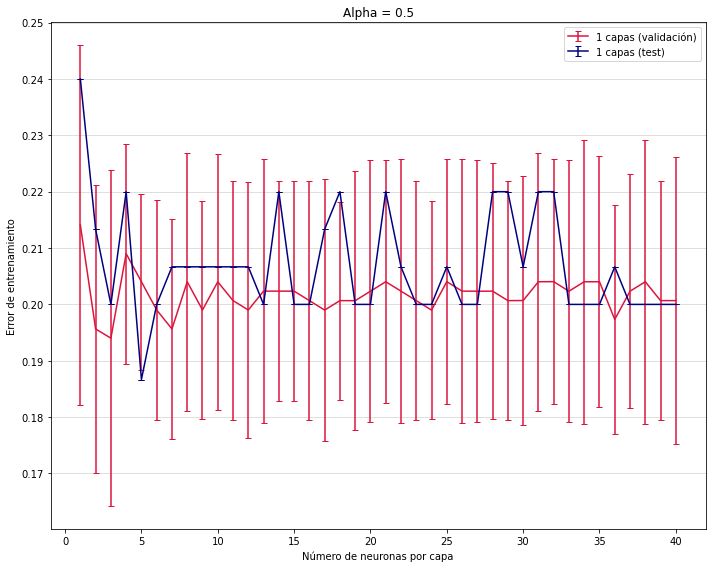

In [23]:
fig_test, axes_test = plt.subplots(1, 1, figsize=(10, 8))

errorVal(cv_results_gf[cv_results_gf['param_alpha'] == 0.5], fig_test, label="(validación)", num_capas=[1])
errorVal(cv_results_test[cv_results_test['param_alpha'] == 0.5], fig_test, color=['navy'], label="(test)", num_capas=[1])

plt.tight_layout()
plt.savefig("ej2_2.pdf", dpi=150)
plt.show()

Vemos que el error de *test* oscila en gran medida entorno al error de validación encontrado. El error de *test* para el valor del hiperparámetro seleccionado por la validación cruzada será:

In [24]:
best_cv_results_test = cv_results_test[(cv_results_test['param_alpha'] == cv_results_best_gf['param_alpha'].item()) & (cv_results_test['param_hidden_layer_sizes'] == cv_results_best_gf['param_hidden_layer_sizes'].item())]
best_cv_results_test.loc[:, ['param_alpha', 'param_hidden_layer_sizes', 'mean_test_score', 'mean_test_error', 'std_test_score', 'rank_test_score']]

,param_alpha,param_hidden_layer_sizes,mean_test_score,mean_test_error,std_test_score,rank_test_score
2,0.5,"(3,)",0.8,0.2,0.0,5


# Ejercicio 3

**Definición de variables globales**

In [14]:
DATASET_NAME3 = 'EnergyEfficiency.data' 

**Lectura del fichero de datos**

In [15]:
dataset3 = pd.read_csv(DATASET_NAME3, 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1, # la primera fila no contiene datos
                      header=None,
                      names = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "Y2"])
dataset3

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,28.28
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.61


**Exploración de los datos**

A continuación, vemos si hay valores perdidos en nuestro conjunto de datos (en caso afirmativo, haremos el tratamiento más adelante). Visualizamos también estadísticas descriptivas de las variables predictoras. 

In [16]:
print(f"Valores faltantes: \n{dataset3.isnull().sum()}\n")
print("Estadísticas de los predictores y la variable dependiente:")
dataset3.describe()

Valores faltantes: 
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y2    0
dtype: int64

Estadísticas de los predictores y la variable dependiente:


,X1,X2,X3,X4,X5,X6,X7,X8,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,48.030000


El fichero contiene 9 variables y 748 observaciones distintas. Las variables predictoras son `X1`, `X2`, `X3`, `X4`, `X5`, `X6`, `X7`, `X8`, y la variable dependiente sería `Y2`. Estamos ante un problema de regresión, dada la naturaleza continua de `Y2`.

**Visualización de los datos**

Muchas variables, si bien cuantitativas, solo discretas, por lo que esperamos gran superposición de los puntos al representar las relaciones por pares.

Correlación numérica entre las variables: 
              X1            X2            X3            X4            X5  \
X1  1.000000e+00 -9.919015e-01 -2.037817e-01 -8.688234e-01  8.277473e-01   
X2 -9.919015e-01  1.000000e+00  1.955016e-01  8.807195e-01 -8.581477e-01   
X3 -2.037817e-01  1.955016e-01  1.000000e+00 -2.923165e-01  2.809757e-01   
X4 -8.688234e-01  8.807195e-01 -2.923165e-01  1.000000e+00 -9.725122e-01   
X5  8.277473e-01 -8.581477e-01  2.809757e-01 -9.725122e-01  1.000000e+00   
X6  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
X7  1.283986e-17  1.318356e-16 -7.969726e-19 -1.381805e-16  1.861418e-18   
X8  1.764620e-17 -3.558613e-16  0.000000e+00 -1.079129e-16  0.000000e+00   
Y2  6.343391e-01 -6.729989e-01  4.271170e-01 -8.625466e-01  8.957852e-01   

         X6            X7            X8        Y2  
X1  0.00000  1.283986e-17  1.764620e-17  0.634339  
X2  0.00000  1.318356e-16 -3.558613e-16 -0.672999  
X3  0.00000 -7.969726e-19  0.000000e+00 

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


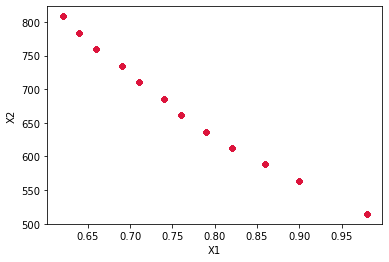

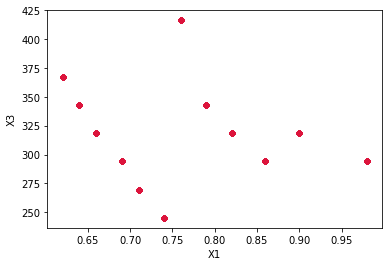

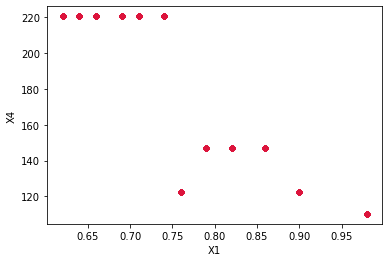

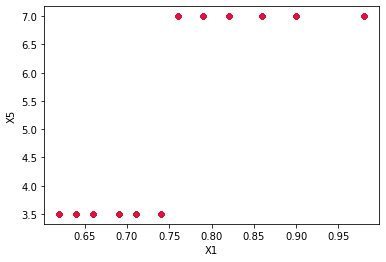

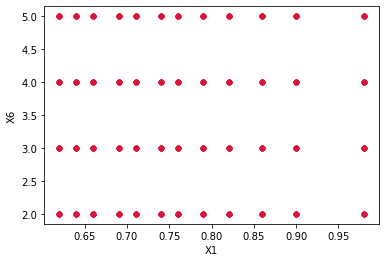

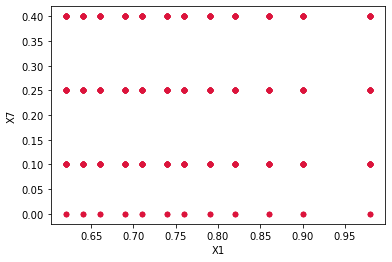

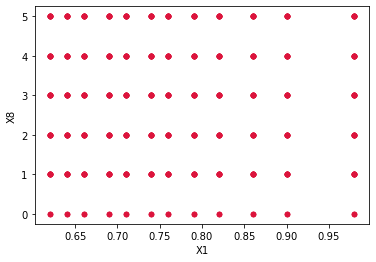

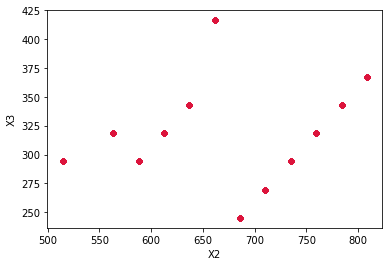

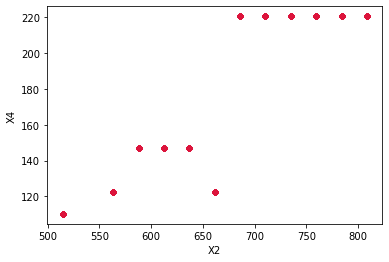

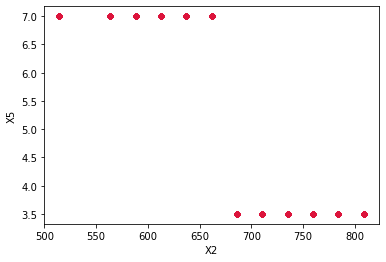

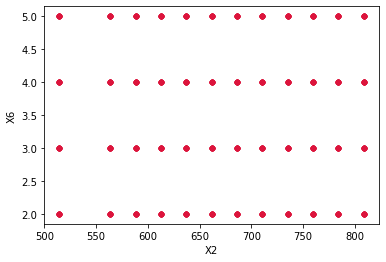

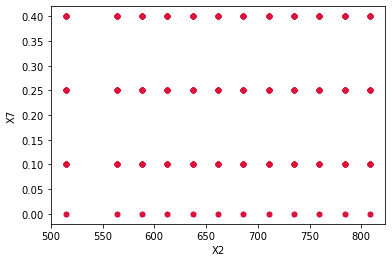

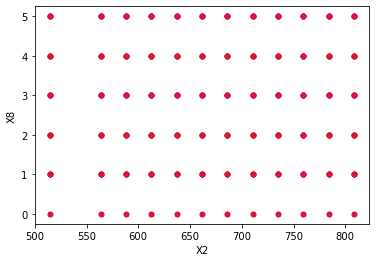

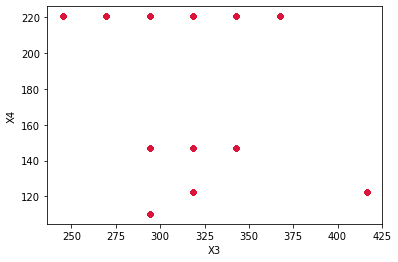

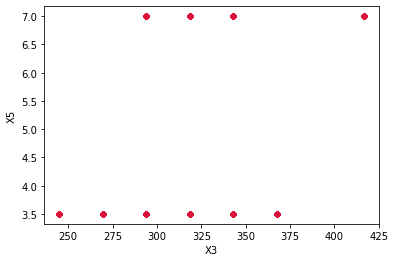

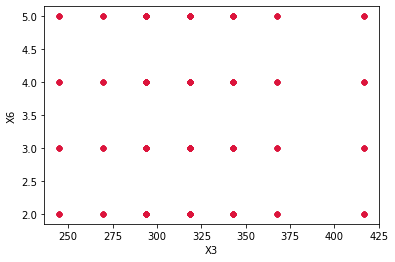

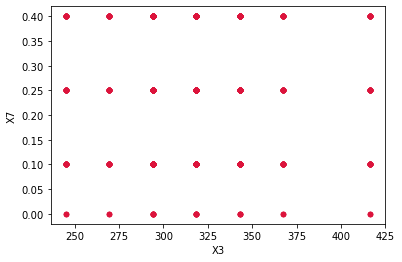

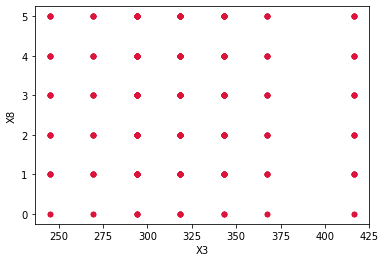

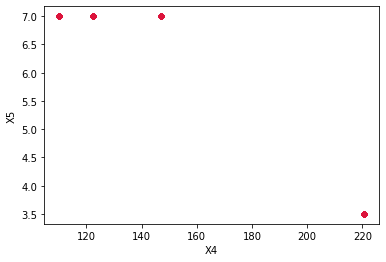

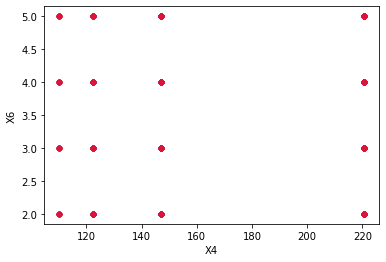

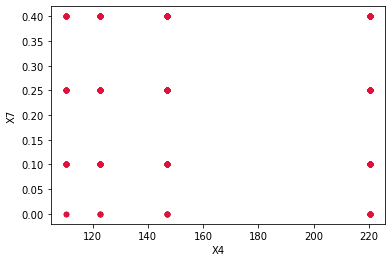

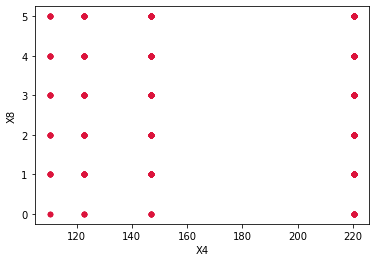

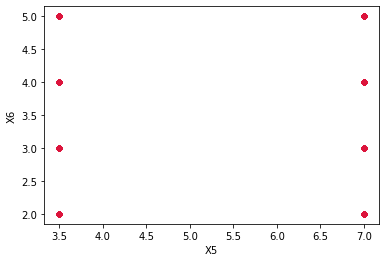

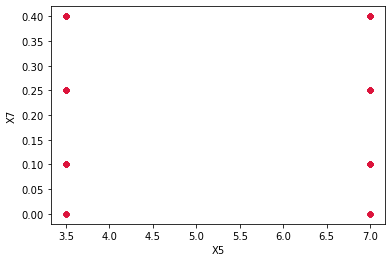

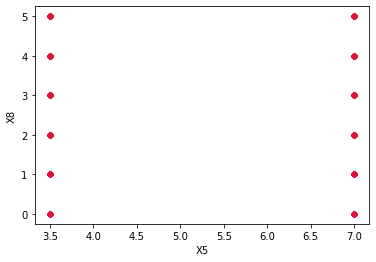

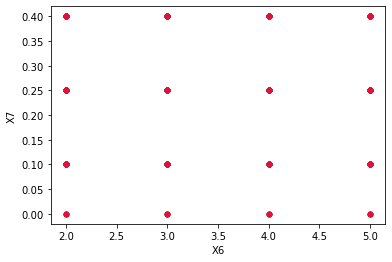

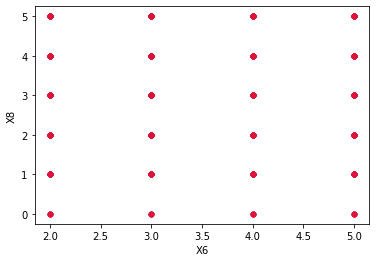

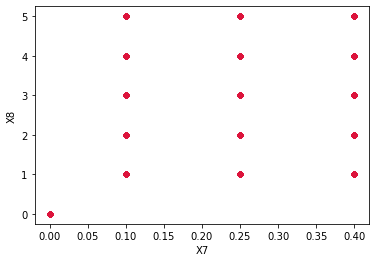

In [17]:
distPares(dataset3)

### División de los datos en entrenamiento (80%) y test (20%)

Para la división de datos entre entrenamiento (80%) y test (20%) usamos `train_test_split`.

In [18]:
dataset_train3, dataset_test3 = train_test_split(dataset3, test_size=0.2, random_state=SEED_VALUE)
dataset_test3

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
285,0.62,808.5,367.5,220.5,3.5,3,0.10,5,13.97
101,0.90,563.5,318.5,122.5,7.0,3,0.10,2,29.44
581,0.90,563.5,318.5,122.5,7.0,3,0.40,2,35.39
352,0.79,637.0,343.0,147.0,7.0,2,0.25,2,43.86
726,0.90,563.5,318.5,122.5,7.0,4,0.40,5,38.79
...,...,...,...,...,...,...,...,...,...
563,0.69,735.0,294.0,220.5,3.5,5,0.40,1,17.20
318,0.71,710.5,269.5,220.5,3.5,4,0.25,1,15.44
154,0.86,588.0,294.0,147.0,7.0,4,0.10,3,25.90
684,0.82,612.5,318.5,147.0,7.0,2,0.40,4,28.20


**Gestión de valores faltantes**

Como ya vimos en la breve exploración e los datos, nuestro dataset no tiene valores faltantes.

In [19]:
dataset_train3, dataset_test3 = valoresFaltantes(dataset_train3, dataset_test3)
dataset_test3

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
285,0.62,808.5,367.5,220.5,3.5,3.0,0.10,5.0,13.97
101,0.90,563.5,318.5,122.5,7.0,3.0,0.10,2.0,29.44
581,0.90,563.5,318.5,122.5,7.0,3.0,0.40,2.0,35.39
352,0.79,637.0,343.0,147.0,7.0,2.0,0.25,2.0,43.86
726,0.90,563.5,318.5,122.5,7.0,4.0,0.40,5.0,38.79
...,...,...,...,...,...,...,...,...,...
563,0.69,735.0,294.0,220.5,3.5,5.0,0.40,1.0,17.20
318,0.71,710.5,269.5,220.5,3.5,4.0,0.25,1.0,15.44
154,0.86,588.0,294.0,147.0,7.0,4.0,0.10,3.0,25.90
684,0.82,612.5,318.5,147.0,7.0,2.0,0.40,4.0,28.20


### Separación de variables predictoras y dependientes y estandarización de los datos

Como ahora estamos en un problema de regresión, es necesario estandarizar también la variable dependiente.

In [20]:
dataset_train_X_scaled3, dataset_train_Y_scaled3, dataset_test_X_scaled3, dataset_test_Y_scaled3, scaler3 = splitScale(dataset_train3, dataset_test3, preds = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'], dep = 'Y2', escalar=[True, True])

Valores con los que se ha estandarizado:

            X1          X2          X3          X4        X5        X6  \
Mean  0.762769  673.191368  318.140879  177.525244  5.198697  3.473941   
std   0.106922   88.806099   43.961322   45.464442  1.749248  1.119186   

            X7        X8  
Mean  0.231922  2.838762  
std   0.132407  1.542576  

             Y2
Mean  24.324870
std    9.453206


### Exploración de hiperparámetros

Hemos visualizado y preprocesado los datos. Vamos a empezar a trabajar con nuestro predictor. Importante conocer los hiperparámetros del modelo a usar. Debemos sobreaprender y subaprender. Primero hacemos exploracion de hiperparámetros de grano grueso y luego de grano fino.

**Exploración de grano grueso**

En esta práctica, exploraremos el parámetro de regularización (`alpha` en `scikit-learn`) y el número de capas (variando entre 1 y 3), así como el número de neuronas en cada capa (que supondremos el mismo en todas las capas). Hacemos primero una exploración de valores en un rango amplio (gg), para subaprender y sobreaprender. De este modo, luego seleccionaremos un rango más limitado de este parámetro y podremos explorar todas las posibilidades en el mismo. Esta vez, el `scoring` será el MSE, aunque `scikit-learn` implementa el -MSE, por lo que deberemos cambiarle el signo.

Concretamente, seleccionamos valores de `alpha` entre 0.001 y 10, en potencias de 10 (0.001, 0.01, 0.1, 1, 10, 10), y de número de capas entre 1 y 3. Cada capa tendrá el mismo número de neuronas, que variará entre 1 y 101, en pasos de 10. Usamos como función de activación la tangente hiperbólica y como algoritmo de optimización el BFGS limitado en memoria. Fijamos un máximo de 2000 iteraciones.

In [32]:
hidden_gg3 = [(n,) for n in range(1, 102, 10)] + [(n, n) for n in range(1, 102, 10)] + [(n, n, n) for n in range(1, 102, 10)]
alpha_gg3 = [1 * 10**p for p in range(-3, 2)]

hyperparameters_gg3 = {'hidden_layer_sizes': hidden_gg3, 'alpha': alpha_gg3}

mlp_gg3 = MLPRegressor(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)

modeloCV_gg3, cv_results_gg3 = crossVal(dataset_train_X_scaled3, np.ravel(dataset_train_Y_scaled3), 
                                        mlp_gg3, hyperparameters_gg3,  
                                        scoring = 'neg_mean_squared_error')
modeloCV_gg3

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn

GridSearchCV(cv=5,
             estimator=MLPRegressor(activation='tanh', max_iter=2000,
                                    random_state=1, solver='lbfgs'),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10],
                         'hidden_layer_sizes': [(1,), (11,), (21,), (31,),
                                                (41,), (51,), (61,), (71,),
                                                (81,), (91,), (101,), (1, 1),
                                                (11, 11), (21, 21), (31, 31),
                                                (41, 41), (51, 51), (61, 61),
                                                (71, 71), (81, 81), (91, 91),
                                                (101, 101), (1, 1, 1),
                                                (11, 11, 11), (21, 21, 21),
                                                (31, 31, 31), (41, 41, 41),
                                                (51, 51, 51), (61, 61, 61),
                   

Es importante tener en cuenta que, al estandarizar la variable dependiente, hay que desestandarizar los campos 'mean_test_score' y 'std_test_score', sin más que multiplicarlo por la varianza de las observaciones de Y del conjunto de entrenamiento. Esta información la tenemos guardada en el `scaler` de estas observaciones. 

In [33]:
_, scalerY3 = scaler3
std_Y_reg = scalerY3.scale_ 
cv_results_gg3['mean_test_score'] = -cv_results_gg3['mean_test_score'] * (std_Y_reg.item())**2
cv_results_gg3['std_test_score'] = cv_results_gg3['std_test_score'] * (std_Y_reg.item())**2

Visualizamos los modelos encontrados en este rango de hiperparámetros, con gráficas del mismo estilo que en el ejercicio anterior.

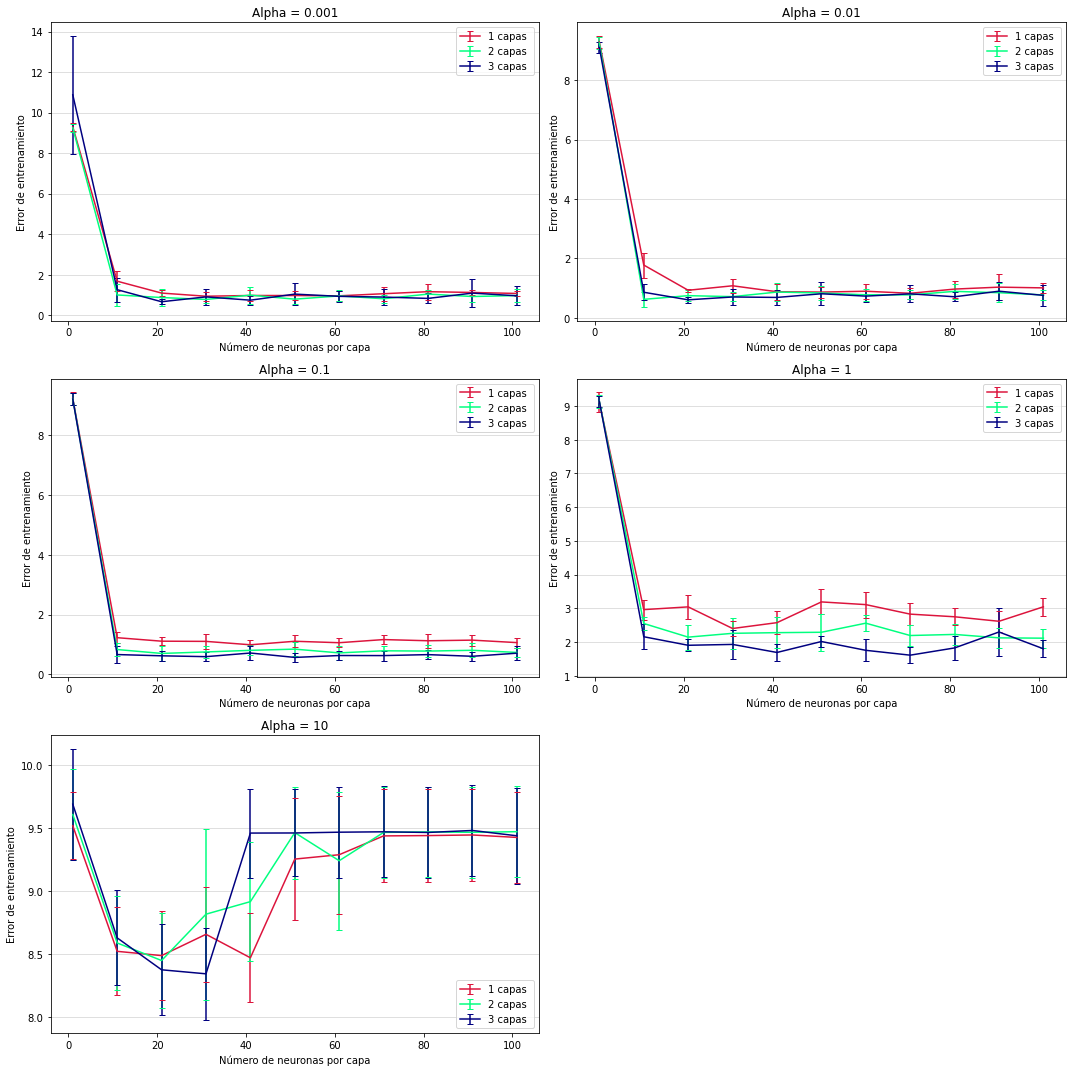

In [ ]:
fig_gg3, axes_gg3 = plt.subplots(3, int(len(alpha_gg3)/2), figsize=(3*len(alpha_gg3), 15))

errorVal(cv_results_gg3, fig_gg3, label="", classification = False)

fig_gg3.delaxes(axes_gg3.flatten()[-1])

plt.tight_layout()
plt.show()

Vemos que con `alpha` < 1 tenemos el menor error de validación cruzada, similar para una, dos o tres capas ocultas y con valores similares para el número de neuronas en un rango relativamente amplio.  

**Exploración de grano fino**

Repetimos la exploración, esta vez barriendo valores de regularización 0.001, 0.005, 0.01, 0.05, 0.1 y 0.5, de nuevo de 1 a 3 capas de neuronas y entre 10 y 35 neuronas en cada capa. Así encontraremos el modelo con el menor error de validación cruzada para este problema.

In [25]:
hidden_gf3 = [(n,) for n in range(10, 35, 1)] + [(n, n) for n in range(10, 35, 1)] + [(n, n, n) for n in range(10, 35, 1)]
alpha_gf3 = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

hyperparameters_gf3 = {'hidden_layer_sizes': hidden_gf3, 'alpha': alpha_gf3}

mlp_gf3 = MLPRegressor(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)

modeloCV_gf3, cv_results_gf3 = crossVal(dataset_train_X_scaled3, np.ravel(dataset_train_Y_scaled3), 
                                        mlp_gf3, hyperparameters_gf3, 
                                        scoring = 'neg_mean_squared_error')
modeloCV_gf3

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn

GridSearchCV(cv=5,
             estimator=MLPRegressor(activation='tanh', max_iter=2000,
                                    random_state=1, solver='lbfgs'),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
                         'hidden_layer_sizes': [(10,), (11,), (12,), (13,),
                                                (14,), (15,), (16,), (17,),
                                                (18,), (19,), (20,), (21,),
                                                (22,), (23,), (24,), (25,),
                                                (26,), (27,), (28,), (29,),
                                                (30,), (31,), (32,), (33,),
                                                (34,), (10, 10), (11, 11),
                                                (12, 12), (13, 13), (14, 14), ...]},
             return_train_score=True, scoring='neg_mean_squared_error')

Desestadarizamos el error y la desviación estándar del mismo modo que antes

In [26]:
cv_results_gf3['mean_test_score'] = -cv_results_gf3['mean_test_score'] * (std_Y_reg.item())**2
cv_results_gf3['std_test_score'] = cv_results_gf3['std_test_score'] * (std_Y_reg.item())**2

Los mejores hiperparámetros en validación cruzada serán los siguientes:

In [27]:
cv_results_best_gf3 = cv_results_gf3[cv_results_gf3['rank_test_score'] == 1]
cv_results_best_gf3.loc[:, ['param_alpha', 'param_hidden_layer_sizes', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_alpha,param_hidden_layer_sizes,mean_test_score,std_test_score,rank_test_score
372,0.1,"(32, 32, 32)",0.479828,0.122977,1


**Gráfica de entrenamiento**

A continuación mostramos la gráfica del error de entrenamiento con validación cruzada frente al número de neuronas por capa.

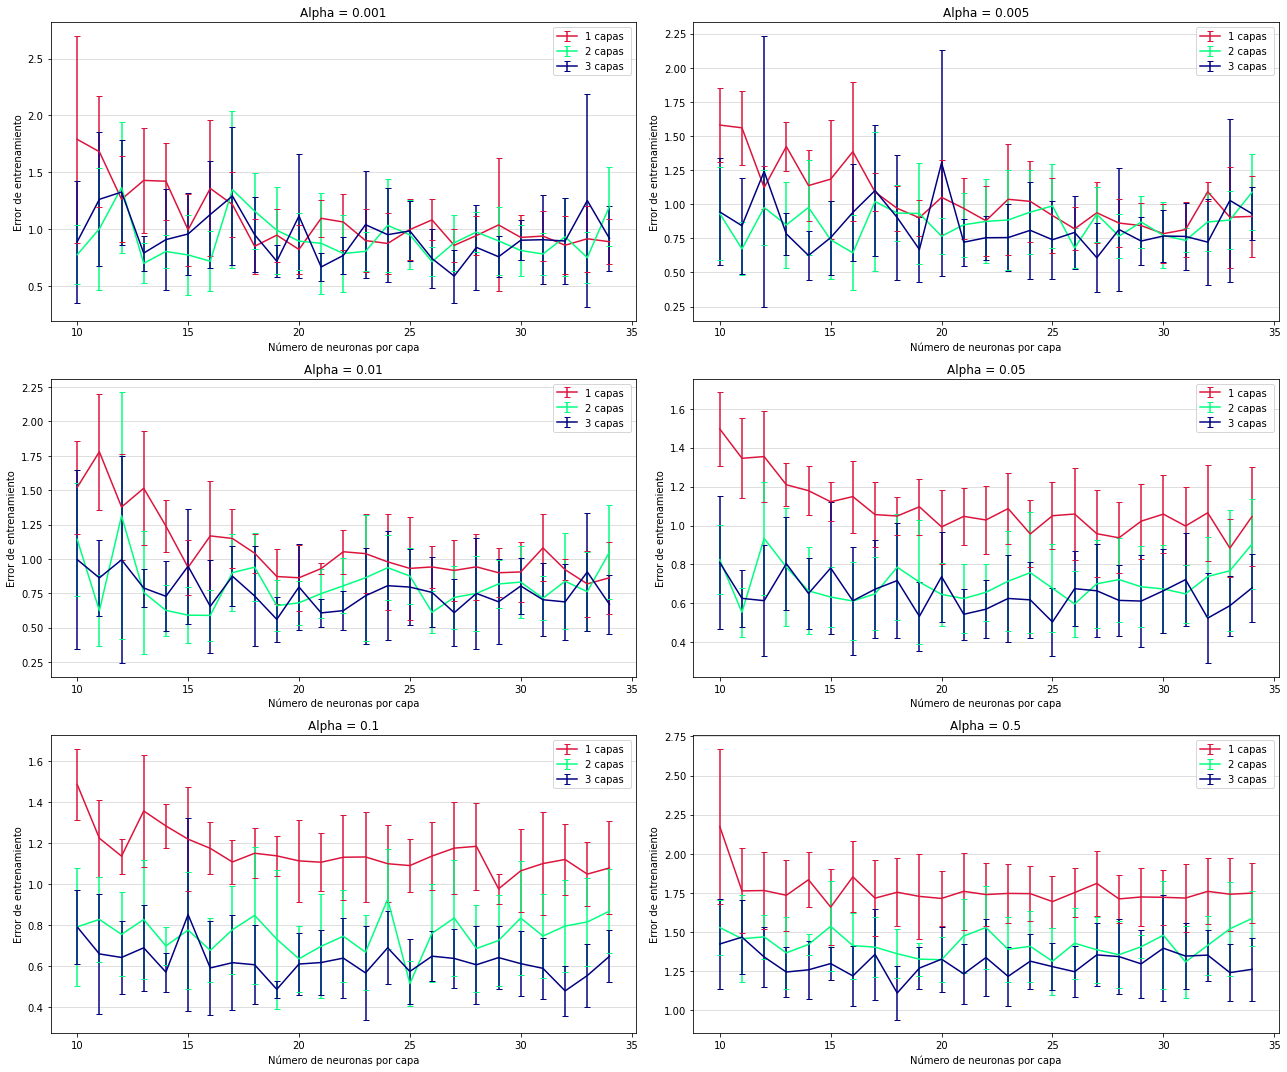

In [28]:
fig_gf3, axes_gf3 = plt.subplots(3, 2, figsize=(3*len(alpha_gf3), 15))

errorVal(cv_results_gf3, fig_gf3, label="", classification = False)

plt.tight_layout()
plt.savefig("ej3_1.pdf", dpi=150)
plt.show()

Aquí podemos ver visualmente los resultados anteriores: el mejor modelo es para un `param_alpha` de 0.1, con tres capas ocultas de 19 neuronas cada una. No obstante, existen muchos modelos con un valor de error en validación cruzada muy similar.

### Verificación de hiperparámetros en *test*

Esto no se haría **JAMÁS** en una situación real. Pero como este es un ejemplo para aprender, vamos a ver cómo de lejos nos hemos quedado de los hiperparámetros "ideales". Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos).

In [29]:
split_test_fold3 = [-1]*len(dataset_train_Y_scaled3) + [0]*len(dataset_test_Y_scaled3)
ps3 = PredefinedSplit(test_fold=split_test_fold3) # fijamos una particion de datos (forzamos al metodo a que particione como queremos)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled3 = np.vstack([dataset_train_X_scaled3, dataset_test_X_scaled3])
dataset_all_Y3 = np.vstack([dataset_train_Y_scaled3, dataset_test_Y_scaled3])

mlp3 = MLPRegressor(activation='tanh', solver='lbfgs', max_iter=2000, random_state=SEED_VALUE)

modeloCV_test3, cv_results_test3 = crossVal(dataset_all_X_scaled3, np.ravel(dataset_all_Y3), 
                                            mlp3, hyperparameters_gf3, 
                                            cv = ps3, scoring = 'neg_mean_squared_error')
modeloCV_test3

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/sklearn

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MLPRegressor(activation='tanh', max_iter=2000,
                                    random_state=1, solver='lbfgs'),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
                         'hidden_layer_sizes': [(10,), (11,), (12,), (13,),
                                                (14,), (15,), (16,), (17,),
                                                (18,), (19,), (20,), (21,),
                                                (22,), (23,), (24,), (25,),
                                                (26,), (27,), (28,), (29,),
                                                (30,), (31,), (32,), (33,),
                                                (34,), (10, 10), (11, 11),
                                                (12, 12), (13, 13), (14, 14), ...]},
             return_train_score=True, scoring='neg_mean_squared_error')

Desestandarizamos el error y la desviación estándar

In [30]:
cv_results_test3['mean_test_score'] = -cv_results_test3['mean_test_score'] * (std_Y_reg.item())**2
cv_results_test3['std_test_score'] = cv_results_test3['std_test_score'] * (std_Y_reg.item())**2

Ahora mostramos la gráfica del error de *test* frente al número de neuronas junto con la del error de entrenamiento, para un valora de `param_alpha` de 0.1 y 3 capas ocultas, lo que permitirá comparar si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de *test*.

/mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


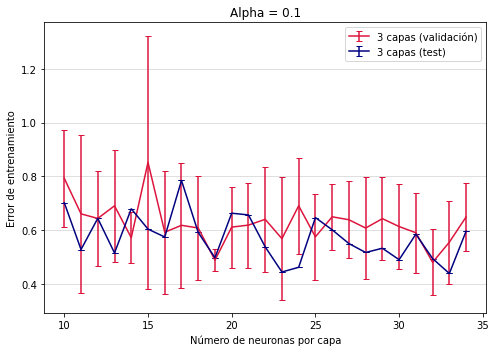

In [31]:
fig_test3, axes_test3 = plt.subplots(1, 1, figsize=(7, 5))

errorVal(cv_results_gf3[cv_results_gf3['param_alpha'] == 0.1], fig_test3, label="(validación)", classification = False, num_capas=[3])
errorVal(cv_results_test3[cv_results_test3['param_alpha'] == 0.1], fig_test3, color=['navy'], label="(test)", classification = False, num_capas=[3])

plt.tight_layout()
plt.savefig("ej3_2.pdf", dpi=150)
plt.show()

Vemos como la evolución de ambos errores con el número de capas es similar; a pesar de las oscilaciones, se encuentran dentro del error de mutuo. El error de *test* para el valor del hiperparámetro seleccionado por la validación cruzada será:

In [32]:
best_cv_results_test3 = cv_results_test3[(cv_results_test3['param_alpha'] == cv_results_best_gf3['param_alpha'].item()) & (cv_results_test3['param_hidden_layer_sizes'] == cv_results_best_gf3['param_hidden_layer_sizes'].item())]
best_cv_results_test3.loc[:, ['param_alpha', 'param_hidden_layer_sizes', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_alpha,param_hidden_layer_sizes,mean_test_score,std_test_score,rank_test_score
372,0.1,"(32, 32, 32)",0.493655,0.0,26
